In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.__version__

'2.3.2'

## Read the dataset

In [3]:
df = pd.read_csv('course_lead_scoring.csv')
print(df.shape[0])

1462


In [4]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Prepare the dataset

- Check if the missing values are presented in the features.
- If there are missing values:
  - For categorical features, replace them with 'NA'
  - For numerical features, replace with with 0.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [8]:
categorical_vars = list(df.select_dtypes(include=['object', 'category']).columns)
print(f'Categorical Vars: {categorical_vars}\n')
numeric_vars = list(df.select_dtypes(exclude=['object', 'category']).columns)
numeric_vars.remove('converted') # --> target var
print(f'Numeric Vars: {numeric_vars}')

Categorical Vars: ['lead_source', 'industry', 'employment_status', 'location']

Numeric Vars: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [9]:
df[categorical_vars] = df[categorical_vars].fillna('NA')
df[numeric_vars] = df[numeric_vars].fillna(0)
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

## Question 1
What is the most frequent observation (mode) for the column industry?

In [10]:
count_industries = df['industry'].value_counts(dropna=False)
print(count_industries)
print(f'\n\nMost Frequest Observation: {count_industries.index[0]}')

industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64


Most Frequest Observation: retail


## Question 2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

- What are the two features that have the biggest correlation?
  - interaction_count and lead_score
  - number_of_courses_viewed and lead_score
  - number_of_courses_viewed and interaction_count
  - annual_income and interaction_count
- Only consider the pairs above when answering this question.

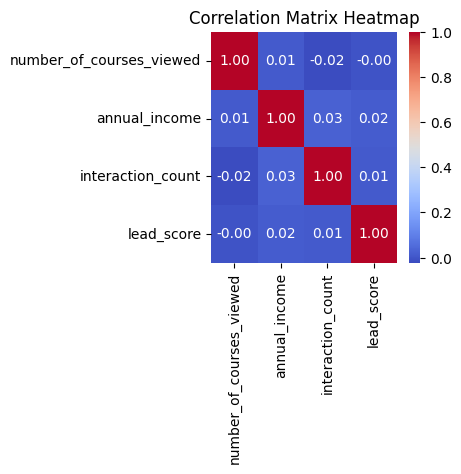

In [11]:
correlation_matrix = df[numeric_vars].corr() 
plt.figure(figsize=(3, 3)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()
# annual_income and interaction_count have the biggest correlation

## Split the data
- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value converted is not in your dataframe.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
print(df_train.shape[0], df_val.shape[0], df_test.shape[0])

876 293 293


## Question 3
- Calculate the mutual information score between converted and other categorical variables in the dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).
- Which of these variables has the biggest mutual information score?

In [14]:
df_train[categorical_vars]

,lead_source,industry,employment_status,location
1077,paid_ads,retail,student,middle_east
463,organic_search,manufacturing,student,middle_east
842,paid_ads,technology,employed,north_america
835,NA,technology,employed,europe
837,organic_search,retail,student,australia
...,...,...,...,...
725,organic_search,other,employed,australia
401,social_media,retail,employed,north_america
957,NA,education,employed,asia
992,social_media,manufacturing,self_employed,europe


In [15]:
from sklearn.metrics import mutual_info_score
mi_score = df_train[categorical_vars].apply(lambda x: mutual_info_score(x, df_train['converted'].values))
mi_score = round(mi_score, 2)
mi_score.sort_values(ascending=False)
# lead_source has the biggest mutual information score

lead_source          0.04
industry             0.01
employment_status    0.01
location             0.00
dtype: float64

## Question 4
```Now let's train a logistic regression.
Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
Fit the model on the training dataset.
To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
Calculate the accuracy on the validation dataset and round it to 2 decimal digits.
What accuracy did you get?
```

In [16]:
# perform one hot encoding
from sklearn.feature_extraction import DictVectorizer

In [17]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical_vars + numeric_vars].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_vars + numeric_vars].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_train = df_train['converted'].values
y_val = df_val['converted'].values

In [18]:
# train model
from sklearn.linear_model import LogisticRegression

In [19]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [20]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [21]:
print(model.intercept_[0])

-0.0691472802783364


In [22]:
print(model.coef_[0])

[-1.77843866e-05 -1.47154423e-02  3.39095225e-02  2.66248432e-03
  1.15238518e-02 -1.02527697e-01 -2.48510995e-02  4.93604222e-02
 -2.01258344e-02 -1.34214865e-02 -3.00232200e-03 -9.25991830e-03
 -3.17957304e-02 -1.60513114e-02  3.11339155e-01  5.12012528e-02
  2.01511698e-02 -1.20346284e-02 -1.16021521e-02 -1.15251880e-01
  7.95303436e-02 -2.99401329e-02  3.95843295e-03 -1.14296944e-02
 -1.12457415e-02 -5.59987025e-03  8.26402635e-03  5.58598769e-03
 -3.33967159e-02 -2.52837052e-02  4.53752887e-01]


In [33]:
dv.get_feature_names_out()

array(['annual_income', 'employment_status=NA',
       'employment_status=employed', 'employment_status=self_employed',
       'employment_status=student', 'employment_status=unemployed',
       'industry=NA', 'industry=education', 'industry=finance',
       'industry=healthcare', 'industry=manufacturing', 'industry=other',
       'industry=retail', 'industry=technology', 'interaction_count',
       'lead_score', 'lead_source=NA', 'lead_source=events',
       'lead_source=organic_search', 'lead_source=paid_ads',
       'lead_source=referral', 'lead_source=social_media', 'location=NA',
       'location=africa', 'location=asia', 'location=australia',
       'location=europe', 'location=middle_east',
       'location=north_america', 'location=south_america',
       'number_of_courses_viewed'], dtype=object)

In [23]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred[0:10]

array([0.61192163, 0.79982617, 0.53021344, 0.47131479, 0.57066132,
       0.44227169, 0.87127669, 0.84883115, 0.83290038, 0.61497802])

In [24]:
predicted_converted = (y_pred >= 0.5)
predicted_converted[0:10]

array([ True,  True,  True, False,  True, False,  True,  True,  True,
        True])

In [25]:
print(f'''Accuracy on the validation dataset: 
{round((y_val == predicted_converted).mean(), 2)}
''')

Accuracy on the validation dataset: 
0.7



## Question 5
```
Let's find the least useful feature using the feature elimination technique.
Train a model using the same features and parameters as in Q4 (without rounding).
Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
Which of following feature has the smallest difference?

'industry'
'employment_status'
'lead_score'
```

In [26]:
original_vars = categorical_vars + numeric_vars

def logit_model_training(features: list, df_train: pd.DataFrame, df_val: pd.DataFrame):
    # one hot encode variables
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    # extract target var
    y_train = df_train['converted'].values
    y_val = df_val['converted'].values
    
    # train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    predicted_converted = (y_pred >= 0.5)
    return ((y_val == predicted_converted).mean())

In [27]:
original_vars = categorical_vars + numeric_vars
all_var_score = logit_model_training(features = original_vars, df_train=df_train, df_val=df_val)
print(f'Accuracy with ALL vars: {all_var_score}')
score_dict = {'all': all_var_score}
for var in original_vars:
    all_vars = categorical_vars + numeric_vars
    all_vars.remove(var)
    removed_var_score = logit_model_training(features = all_vars, df_train=df_train, df_val=df_val)
    score_dict[var] = removed_var_score
    print(f'Accuracy after removing {var}: {removed_var_score}')

Accuracy with ALL vars: 0.6996587030716723
Accuracy after removing lead_source: 0.7030716723549488
Accuracy after removing industry: 0.6996587030716723
Accuracy after removing employment_status: 0.6962457337883959
Accuracy after removing location: 0.7098976109215017
Accuracy after removing number_of_courses_viewed: 0.5563139931740614
Accuracy after removing annual_income: 0.8532423208191127
Accuracy after removing interaction_count: 0.5563139931740614
Accuracy after removing lead_score: 0.7064846416382252


In [28]:
score_dict

{'all': np.float64(0.6996587030716723),
 'lead_source': np.float64(0.7030716723549488),
 'industry': np.float64(0.6996587030716723),
 'employment_status': np.float64(0.6962457337883959),
 'location': np.float64(0.7098976109215017),
 'number_of_courses_viewed': np.float64(0.5563139931740614),
 'annual_income': np.float64(0.8532423208191127),
 'interaction_count': np.float64(0.5563139931740614),
 'lead_score': np.float64(0.7064846416382252)}

In [29]:
score_diff = {}
for key in score_dict:
    score_diff[key] = score_dict['all'] - score_dict[key]

del score_diff['all']

In [30]:
score_diff_df = pd.DataFrame.from_dict(score_diff, orient='index')
score_diff_df.sort_values(by=0)
# industry -- removing industry doesn't change the accuracy

,0
annual_income,-0.153584
location,-0.010239
lead_score,-0.006826
lead_source,-0.003413
industry,0.000000
employment_status,0.003413
number_of_courses_viewed,0.143345
interaction_count,0.143345


## Question 6
```
Now let's train a regularized logistic regression.
Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
Train models using all the features as in Q4.
Calculate the accuracy on the validation dataset and round it to 3 decimal digits.
Which of these C leads to the best accuracy on the validation set?

0.01
0.1
1
10
100
```

In [31]:
original_vars = categorical_vars + numeric_vars

def prep_features_modeling(df_train, df_val, features):
    # one hot encode variables
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    # extract target var
    y_train = df_train['converted'].values
    y_val = df_val['converted'].values

    return X_train, y_train, X_val, y_val
    
def logit_regularized_model_training(X_train, y_train, X_val, y_val, features, c):
    # train model
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    predicted_converted = (y_pred >= 0.5)
    return ((y_val == predicted_converted).mean())


X_train, y_train, X_val, y_val = prep_features_modeling(df_train, df_val, original_vars)
param_score_dict = {}
param_list = [0.01, 0.1, 1, 10, 100]
for c in param_list:
    param_score_dict[c] = round(logit_regularized_model_training(X_train, y_train, X_val, y_val, original_vars, c), 3)
param_score_dict

# since the accuracy scores are same, picking 0.01 c as the option

{0.01: np.float64(0.7),
 0.1: np.float64(0.7),
 1: np.float64(0.7),
 10: np.float64(0.7),
 100: np.float64(0.7)}